
# Checking and Downloading Dataset
link: https://github.com/mahdi-darvish/YOLOv3-from-Scratch-Analaysis-and-Implementation/blob/main/implementations/dataset.py
menggunakan dan memodifikasii

## 00 Importing Libraries and setting up device-agnostic code

In [ ]:
# Creates a Pytorch dataset to load the Pascal VOC & MS COCO datasets
import os
import torch
import pandas as pd
import numpy as np
import PIL

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torch import nn
# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'2.3.1+cu121'

## 01 Get the data

In [ ]:
from google.colab import drive

# Connect to google drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download train and test set

In [ ]:
import os
import shutil

# Tentukan path folder di Google Drive dan path tujuan di Colab
gdrive_folder = '/content/drive/MyDrive/dataset_split/'
colab_folder = '/content/dataset'

# Cek apakah folder sudah ada di Colab
if not os.path.exists(colab_folder):
    # Jika folder belum ada, salin folder dari Google Drive ke Colab
    shutil.copytree(gdrive_folder, colab_folder)
    print(f"Folder {gdrive_folder} telah disalin ke {colab_folder}.")
else:
    print(f"Folder {colab_folder} sudah ada di Colab.")

Folder /content/drive/MyDrive/dataset_split/ telah disalin ke /content/dataset.


### Matching data labels and data images
yolo format:
* class, x_center, y_centre, height, width
* (0 < x_center <= 1 and 0 < y_center <= 1 and 0 < width <= 1 and 0 < height <= 1):

### Matching data labels and data images

In [ ]:
# Path directory train and test data
image_train_dir = '/content/dataset/train/images'
label_train_dir = '/content/dataset/train/labels'
image_test_dir = '/content/dataset/test/images'
label_test_dir = '/content/dataset/test/labels'

In [ ]:
# check the number of images and labels
print(len(os.listdir(image_train_dir)))
print(len(os.listdir(label_train_dir)))
print(len(os.listdir(image_test_dir)))
print(len(os.listdir(label_test_dir)))

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/train/images'

In [ ]:
# import os
# import numpy as np

# def check_yolo_format(file_path):
#     """
#     Check if a YOLO format label file is correct.

#     Args:
#     - file_path (str): Path to the label file.

#     Returns:
#     - bool: True if all labels in the file are in YOLO format, False otherwise.
#     """
#     try:
#         # Load the data from the label file
#         data = np.loadtxt(file_path, delimiter=" ", ndmin=2)

#         # Check if each label in the file follows the YOLO format
#         for line in data:
#             if len(line) != 5:
#                 print(f"Error: Line {line} in {file_path} does not have 5 elements.")
#                 return False

#             class_id, x_center, y_center, width, height = line

#             if not (0 < x_center <= 1 and 0 < y_center <= 1 and 0 < width <= 1 and 0 < height <= 1):
#                 print(f"Error: Line {line} in {file_path} has values out of range [0, 1].")
#                 return False

#             if not isinstance(x_center, float) or not isinstance(y_center, float) or \
#                not isinstance(width, float) or not isinstance(height, float):
#                 print(f"Error: Line {line} in {file_path} contains non-float values.")
#                 return False

#         return True

#     except Exception as e:
#         print(f"Error processing file {file_path}: {e}")
#         return False

# def check_all_labels(img_dir, label_dir):
#     """
#     Check all label files in the label directory.

#     Args:
#     - img_dir (str): Directory containing image files.
#     - label_dir (str): Directory containing label files.
#     """
#     image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
#     for img_file in image_files:
#         label_file = img_file.replace('.jpg', '.txt')
#         img_path = os.path.join(img_dir, img_file)
#         label_path = os.path.join(label_dir, label_file)

#         if not os.path.exists(label_path):
#             print(f"Label file {label_file} does not exist.")
#             os.remove(img_path)
#             print(f"Image file {img_file} deleted.")
#             continue

#         is_valid = check_yolo_format(label_path)
#         if is_valid:
#             pass
#         else:
#             print(f"{label_file} is NOT in YOLO format. Deleting the file...")
#             os.remove(label_path)  # Menghapus file label yang tidak valid
#             os.remove(img_path)    # Menghapus file gambar yang sesuai
#             print(f"Image file {img_file} deleted.")

# # Example usage
# check_all_labels(image_train_dir, label_train_dir)
# check_all_labels(image_test_dir, label_test_dir)

In [ ]:
# # check the number of images and labels
# print(len(os.listdir(image_train_dir)))
# print(len(os.listdir(label_train_dir)))
# print(len(os.listdir(image_test_dir)))
# print(len(os.listdir(label_test_dir)))

## 02 becoming one with the data

In [ ]:
class_names = ['person', 'motorcycle', 'car']

#### M
*noted:* Walaupun ada proses normalisasi dalam transformasi, normalisasi ini tidak mengubah nilai piksel secara signifikan karena mean dan std yang digunakan adalah nilai default (0 dan 1). Jika Anda ingin menyesuaikan normalisasi lebih lanjut, Anda mungkin perlu menyesuaikan nilai mean dan std berdasarkan statistik dari dataset Anda.

### Check and display random image with boxes from the dataset

In [ ]:
import random
import matplotlib.pyplot as plt
import glob
import cv2

def display_random_image_with_boxes(image_folder, label_folder, class_names, seed=42):
  """
    Menampilkan gambar secara acak dengan kotak pembatas dan label yang diresize.

    Args:
    - image_folder (str): Path ke folder gambar.
    - label_folder (str): Path ke folder label.
    - class_names (list): Daftar nama kelas.
    - scale_factor (float): Faktor skala untuk memperbesar gambar.
    """

  # Set seed untuk konsistensi
  # torch.manual_seed(seed)
  # random.seed(seed)

  # Path ke folder gambar dan label
  image_folder = image_folder
  label_folder = label_folder

  # Mendapatkan daftar semua file gambar
  image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

  # Memilih gambar secara acak
  random_image_file = random.choice(image_files)
  image_path = os.path.join(image_folder, random_image_file)

  # Mendapatkan nama file tanpa ekstensi
  image_name, _ = os.path.splitext(random_image_file)

  # Path untuk file label yang sesuai
  label_path = os.path.join(label_folder, f"{image_name}.txt")

  # Membaca gambar
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Secara default, OpenCV membaca gambar dalam format BGR

  # Faktor skala untuk memperbesar gambar
  new_width = int(image.shape[1]*(980/image.shape[1]))
  new_height = int(image.shape[0]*(582/image.shape[0]))
  new_dim = (new_width, new_height)

  # Resize gambar
  resized_image = cv2.resize(image, new_dim, interpolation=cv2.INTER_LINEAR)

  # Membaca label dan menggambar kotak pembatas
  if os.path.exists(label_path):
      with open(label_path, 'r') as f:
          lines = f.readlines()
          for line in lines:
              class_id, x_center, y_center, width, height = map(float, line.strip().split())
              img_h, img_w, _ = resized_image.shape

              # Mendapatkan koordinat kotak pembatas
              x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
              x_min, y_min = int(x_center - width / 2), int(y_center - height / 2)
              x_max, y_max = int(x_center + width / 2), int(y_center + height / 2)

              # Menentukan warna berdasarkan class_id
              if class_id == 0:
                  color = (255, 4, 3)  # Warna merah untuk kelas 0
              elif class_id == 1:
                  color = (3, 255, 2)  # Warna hijau untuk kelas 1
              elif class_id == 2:
                  color = (2, 5, 255)  # Warna biru untuk kelas 2
              else:
                  color = (255, 255, 0)  # Warna kuning sebagai default

              # Gambar kotak pembatas pada gambar
              cv2.rectangle(resized_image, (x_min, y_min), (x_max, y_max), color, 2)
              if y_min > 20:
                cv2.putText(resized_image, f"{class_names[int(class_id)]}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
              else:
                cv2.putText(resized_image, f"{class_names[int(class_id)]}", (x_min, y_max + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

  # Menampilkan gambar
  plt.figure(figsize=(12, 8))  # Menyesuaikan ukuran tampilan gambar
  plt.imshow(resized_image)
  plt.axis('off')
  plt.show()

display_random_image_with_boxes(
    image_train_dir,
    label_train_dir,
    class_names
)

display_random_image_with_boxes(
    image_test_dir,
    label_test_dir,
    class_names
)

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/train/images'

### Checking size, shape, label format, and other from dataset

In [ ]:
# Mendapatkan daftar semua file label
label_files = [f for f in os.listdir(label_train_dir) if f.endswith('.txt')]

# Membatasi hanya untuk 10 file pertama
label_files = label_files[:5]

# Membaca dan menampilkan konten setiap file label
for label_file in label_files:
    label_path = os.path.join(label_train_dir, label_file)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        print(f"Label untuk file {label_file}:")
        for line in lines:
            print(line.strip())
        print()  # Untuk pemisah antar file label

NameError: name 'label_train_dir' is not defined

Random image file: video6_frame_19.jpg
Image height: 1080
Image width: 960
Image mode: RGB
class names: ['person', 'motorcycle', 'car']

Labels for video6_frame_19.txt:
1 0.128772 0.325862 0.131897 0.310345
0 0.108405 0.160345 0.106681 0.172414


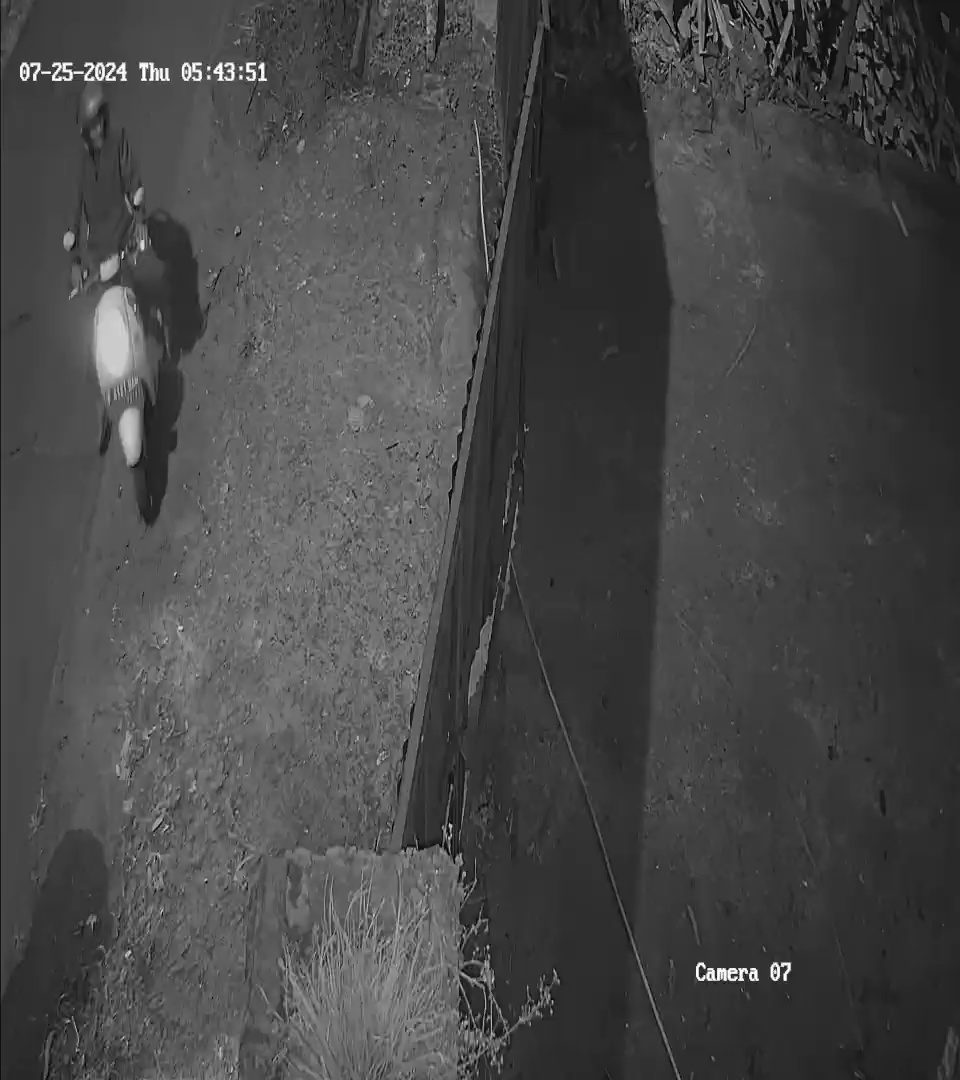

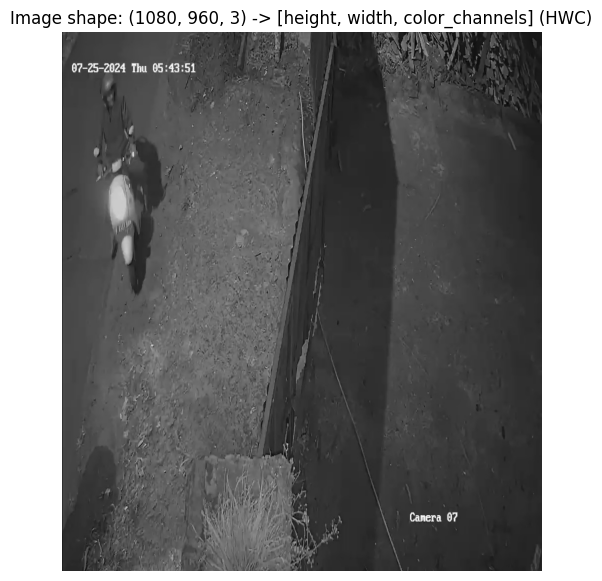

In [ ]:
import numpy as np

# Get all image paths
image_files = [f for f in os.listdir(image_train_dir) if f.endswith('.jpg')]

# Pick a random image path
random_image_file = random.choice(image_files)

# Open Image
img = Image.open(image_train_dir + "/" + random_image_file)

# Mendapatkan nama file tanpa ekstensi
image_name, _ = os.path.splitext(random_image_file)

# Path untuk file label yang sesuai
label_path = os.path.join(label_train_dir, f"{image_name}.txt")

# Print metadata
print(f"Random image file: {random_image_file}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image mode: {img.mode}")
print(f"class names: {class_names}")

# Membaca dan menampilkan konten file label (jika ada)
if os.path.exists(label_path):
    print(f"\nLabels for {image_name}.txt:")
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            print(line.strip())
else:
    print("\nNo label file found for this image.\n")

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);
img

# YOLOv3 Object Deetection

In [ ]:
print(image_train_dir)
print(label_train_dir)
print(image_test_dir)
print(label_test_dir)

NameError: name 'image_train_dir' is not defined

## 03 Model: YOLOv3

biasanya darknet di pretrained dulu dari image net (klasiikasi gambar)

https://www.youtube.com/watch?v=Grir6TZbc1M

In [ ]:
import torch
import torch.nn as nn

# Tuple: (out_channels, kernel_size, stride)
# List is structured by "B" indicating a residual block followed by the number of repeats
# "S" is for scale prediction block and computing the yolo loss
# "U" is for upsampling the feature map and concatenating with a previous layer

config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs) #kernel size and stride and padding(**kwargs)
    self.bn = nn.BatchNorm2d(out_channels)
    self.leaky = nn.LeakyReLU(0.1)
    self.use_bn_act = bn_act

  def forward(self, x):
    if self.use_bn_act:
      return self.leaky(self.bn(self.conv(x)))
    else:
      return self.conv(x)


class ResidualBlock(nn.Module):
  def __init__(self, channels, use_residual=True, num_repeats=1):
    super().__init__()
    self.layers = nn.ModuleList()
    for repeat in range(num_repeats):
      self.layers += [
        nn.Sequential(
          CNNBlock(channels, channels // 2, kernel_size=1),
          CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
        )
      ]

    self.use_residual = use_residual
    self.num_repeats = num_repeats

  def forward(self, x):
    for layer in self.layers:
      x = layer(x) + x if self.use_residual else layer(x)

    return x

class ScalePrediction(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.pred = nn.Sequential(
      CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
      CNNBlock(
          2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1
      ),
    )
    self.num_classes = num_classes

  def forward(self, x):
    return (
      self.pred(x)
      .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
      .permute(0, 1, 3, 4, 2)
    )

class YOLOv3(nn.Module):
  def __init__(self, in_channels=3, num_classes=80):
    super().__init__()
    self.num_classes = num_classes
    self.in_channels = in_channels
    self.layers = self._create_conv_layers()

  def forward(self, x):
    outputs = []
    route_connections = []

    for layer in self.layers:
      if isinstance(layer, ScalePrediction):
        outputs.append(layer(x))
        continue

      x = layer(x)
      # print(x.shape) # Kalau kamu lihatt ukuran ketika di jalankan

      if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
        route_connections.append(x)

      elif isinstance(layer, nn.Upsample):
        x = torch.cat([x, route_connections[-1]], dim=1)
        route_connections.pop()

    return outputs

  def _create_conv_layers(self):
    layers = nn.ModuleList()
    in_channels = self.in_channels

    for module in config:
      if isinstance(module, tuple):
        out_channels, kernel_size, stride = module
        layers.append(
            CNNBlock(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=1 if kernel_size == 3 else 0,
            )
        )
        in_channels = out_channels

      elif isinstance(module, list):
        num_repeats = module[1]
        layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

      elif isinstance(module, str):
        if module == "S":
            layers += [
                ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                ScalePrediction(in_channels // 2, num_classes=self.num_classes),
            ]
            in_channels = in_channels // 2

        elif module == "U":
            layers.append(nn.Upsample(scale_factor=2),)
            in_channels = in_channels * 3

    return layers

if __name__ == "__main__":
  num_classes = 3
  IMAGE_SIZE = 416
  model = YOLOv3(num_classes=num_classes)
  x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
  out = model(x)
  assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
  assert model(x)[1].shape == (2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
  assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
  print("Success!")

Success!


### checking the model with our dataset

In [ ]:
model = YOLOv3(num_classes=3, in_channels=3)

# Ubah gambar ke format yang sesuai dengan model (misalnya, normalisasi, resize)
img = cv2.imread(image_train_dir + "/" + random_image_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (416, 416))
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img_tensor = torch.from_numpy(img_rgb).float().div(255.0).unsqueeze(0)

# Memeriksa ukuran dan format tensor
print("Ukuran tensor:", img_tensor.shape)
print("Format tensor:", img_tensor.dtype)

img_tensor=img_tensor.permute(0, 3, 1, 2)

NameError: name 'image_train_dir' is not defined

In [ ]:
# Gunakan model untuk prediksi
model.eval()  # Set model ke mode evaluasi
with torch.no_grad():  # Tidak perlu menghitung gradien
    detections = model(img_tensor)  # Dapatkan prediksi

print(f"ukuran detections dim 1; {len(detections)}")
print(f"ukuran detections dim 2; {len(detections[0])}")
print(f"ukuran detections dim 2; {len(detections[1])}")
print(f"ukuran detections dim 2; {len(detections[2])}")
print(f"ukuran detections dim 3; {len(detections[0][0])}")
print(f"ukuran detections dim 4; {len(detections[0][0][0])}")
print(f"ukuran detections dim 4; {len(detections[1][0][0])}")
print(f"ukuran detections dim 4; {len(detections[2][0][0])}")
print(f"ukuran detections dim 5; {len(detections[0][0][0][0])}")
print(f"ukuran detections dim 5: {len(detections[1][0][0][0])}")
print(f"ukuran detections dim 5: {len(detections[2][0][0][0])}")
print(f"dim 6: {detections[1][0][0][0].shape}")
print(f"detections:{detections[1][0][0]}")
print(len(detections))
print(detections[1].shape)

In [ ]:
for detection in detections:
  print("Ukuran output tensor:", detection.shape)
  print("Format output tensor:", detection.dtype)

## 03.5 Utilities we  use on this yolo model

from this git hub repository: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/YOLOv3/utils.py

i copy this instead of download and using it from github because i can read and understand the fuctions

In [ ]:
# import config
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch

from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm


def iou_width_height(boxes1, boxes2):

    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = CUSTOM_CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )
    plt.show()

def get_evaluation_bboxes(
    loader,
    model,
    iou_threshold,
    anchors,
    threshold,
    box_format="midpoint",
    device="cuda",
    ):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        # we just want one bbox for each label, not one for each scale
        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.
    INPUT:
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()

def check_class_accuracy(model, loader, threshold):
    model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    for idx, (x, y) in enumerate(tqdm(loader)):
        x = x.to(DEVICE)
        with torch.no_grad():
            out = model(x)

        for i in range(3):
            y[i] = y[i].to(DEVICE)
            obj = y[i][..., 0] == 1 # in paper this is Iobj_i
            noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

            correct_class += torch.sum(
                torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
            )
            tot_class_preds += torch.sum(obj)

            obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
            correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
            tot_obj += torch.sum(obj)
            correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
            tot_noobj += torch.sum(noobj)

    print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
    model.train()


def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    # checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def plot_couple_examples(model, loader, thresh, iou_thresh, anchors):
    model.eval()
    x, y = next(iter(loader))
    x = x.to("cuda")
    with torch.no_grad():
        out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, A, S, _, _ = out[i].shape
            anchor = anchors[i]
            boxes_scale_i = cells_to_bboxes(
                out[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        model.train()

    for i in range(batch_size):
        nms_boxes = non_max_suppression(
            bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
        )
        plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)



def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def get_loaders():
  train_dataset = YOLODataset(
      img_dir=IMG_TRAIN_DIR,
      label_dir=LABEL_TRAIN_DIR,
      anchors=ANCHORS,
      S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
      transform=train_transforms,
  )
  test_dataset = YOLODataset(
      img_dir=IMG_TEST_DIR,
      label_dir=LABEL_TEST_DIR,
      anchors=ANCHORS,
      S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
      transform=test_transforms,
  )
  train_loader = DataLoader(
      dataset=train_dataset,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True,
      drop_last=False,
  )
  test_loader = DataLoader(
      dataset=test_dataset,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=False,
      drop_last=False,
  )

  train_eval_loader = DataLoader(
      dataset=train_dataset,  # Menggunakan train_dataset yang sama
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=False,
      drop_last=False,
  )

  return train_loader, test_loader, train_eval_loader

### faster non max suppresion

In [ ]:
# !!!! tidak menjalankan fungsi non_max_supression
# import torch
# import torchvision.ops as ops

# def non_max_suppression(bboxes, iou_threshold, threshold, box_format="midpoint"):
#     assert type(bboxes) == list

#     # Filter bounding boxes dengan confidence score di atas threshold
#     bboxes = [box for box in bboxes if box[1] > threshold]
#     if len(bboxes) == 0:
#         return []

#     # Ekstrak kelas, scores, dan bounding box dari bboxes
#     boxes = torch.tensor([box[2:] for box in bboxes])
#     scores = torch.tensor([box[1] for box in bboxes])
#     class_labels = torch.tensor([box[0] for box in bboxes])

#     # Menggunakan NMS bawaan dari Torchvision
#     keep_indices = ops.nms(boxes, scores, iou_threshold)

#     # Menggabungkan hasil NMS dengan class label dan score asli
#     final_boxes = [bboxes[i] for i in keep_indices]

#     return final_boxes

## 04 Dataset yolov3

targets adalah list yang berisi tensor dengan format untuk setiap skala deteksi YOLO. Setiap tensor memiliki bentuk (num_anchors // 3, S, S, 6), di mana:

* num_anchors // 3 adalah jumlah anchor boxes per skala.
* S adalah ukuran grid untuk skala tersebut (misalnya, 13, 26, atau 52).
* 6 adalah jumlah fitur yang disimpan untuk setiap cell grid dan anchor box: [p_o, x, y, w, h, c].

Elemen dalam tensor targets
* p_o: Probability that an anchor box contains an object (1 if it does, 0 otherwise).
* x: X coordinate of the bounding box center relative to the grid cell (between 0 and 1).
* y: Y coordinate of the bounding box center relative to the grid cell (between 0 and 1).
* w: Width of the bounding box relative to the grid cell. Can be greater than 1.
* h: Height of the bounding box relative to the grid cell. Can be greater than 1.
* c: Class label of the object

In [ ]:
#import config
import torch
import os
import pandas as pd

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
# from utils import (
#   iou_width_height as iou,
#   non_max_suppression as nms,
# ) - i copy the code, so its already in the environment

ImageFile.LOAD_TRUNCATED_IMAGES = True


class YOLODataset(Dataset):
  def __init__(self, img_dir, label_dir, anchors, image_size=416, S=[13, 26, 52], C=3, transform=None):
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.image_size = image_size
    self.transform = transform
    self.S = S
    self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
    self.num_anchors = self.anchors.shape[0]
    self.num_anchors_per_scale = self.num_anchors // 3
    self.C = C
    self.ignore_iou_thresh = 0.5

    # Get the list of image filenames (assuming they all have the same name in both image and label directories)
    self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

  def __len__(self):
      return len(self.image_files)

  def __getitem__(self, index):
    img_file = self.image_files[index]
    img_path = os.path.join(self.img_dir, img_file)
    label_file = img_file.replace('.jpg', '.txt')
    label_path = os.path.join(self.label_dir, label_file)

    # Handle case where label file is missing or empty
    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
    else:
        bboxes = []  # No objects

    image = np.array(Image.open(img_path).convert("RGB"))

    if self.transform:
        augmentations = self.transform(image=image, bboxes=bboxes)
        image = augmentations["image"]
        bboxes = augmentations["bboxes"]

    # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
    targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S] #[p_o, x, y, w, h, c]

    # which cells anchors should be responsible
    for box in bboxes:
      iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
      anchor_indices = iou_anchors.argsort(descending=True, dim=0)
      x, y, width, height, class_label = box
      has_anchor = [False] * 3  # each scale should have one anchor

      for anchor_idx in anchor_indices:
        scale_idx = anchor_idx // self.num_anchors_per_scale # 0, 1, 2
        anchor_on_scale = anchor_idx % self.num_anchors_per_scale
        S = self.S[scale_idx]
        i, j = int(S * y), int(S * x)  # which cell
        anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

        if not anchor_taken and not has_anchor[scale_idx]:
          targets[scale_idx][anchor_on_scale, i, j, 0] = 1
          x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
          width_cell, height_cell = (
            width * S,
            height * S,
          )  # can be greater than 1 since it's relative to cell
          box_coordinates = torch.tensor(
            [x_cell, y_cell, width_cell, height_cell]
          )
          targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
          targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
          has_anchor[scale_idx] = True

        elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
          targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

    return image, tuple(targets)

In [ ]:
# train_dataset = YOLODataset(
#       img_dir= image_test_dir,
#       label_dir=label_test_dir,
#       anchors= ANCHORS,
#       S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
#       transform=test_transforms
#   )
# # Ambil sampel pertama
# image, targets = train_dataset[0]

# # Periksa ukuran gambar dan target
# print("Ukuran gambar:", image.shape)
# for target in targets:
#     print("Ukuran target:", target.shape)
# image[0][2].shape

## 05 loss functions


In [ ]:
import torch
import torch.nn as nn

# from utils import intersection_over_union | pake google colab aku disatuin semua


class YoloLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()
    self.bce = nn.BCEWithLogitsLoss()
    self.entropy = nn.CrossEntropyLoss()
    self.sigmoid = nn.Sigmoid()


    # Constants -> how much each loss should be valued
    self.lambda_class = 1
    self.lambda_noobj = 30 # Ini membantu mengurangi jumlah deteksi objek yang salah
    self.lambda_obj = 2
    self.lambda_box = 10

  def forward(self, predictions, target, anchors):
    obj = target[..., 0] == 1 # in paper this is Iobj_i
    noobj = target[..., 0] == 0 # in paper this is Iobj_i

    # No Object loss
    no_object_loss = self.bce(
        (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
    )

    # Objcet Loss
    anchors = anchors.reshape(1, 3, 1, 1, 2) # 3 x 2 (anchors in 1 scale x [height, width])
    box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
    ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
    object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

    # Box Coordinate Loss
    predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) # x, y to be between [0,1]
    target[..., 3:5] = torch.log(
        (1e-16 + target[..., 3:5] / anchors)
    ) # width, height coordinate
    box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj],)

    # Class Loss
    class_loss = self.entropy(
      (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
    )

    #print("__________________________________")
    #print(self.lambda_box * box_loss)
    #print(self.lambda_obj * object_loss)
    #print(self.lambda_noobj * no_object_loss)
    #print(self.lambda_class * class_loss)
    #print("\n")

    return (
      self.lambda_box * box_loss
      + self.lambda_obj * object_loss
      + self.lambda_noobj * no_object_loss
      + self.lambda_class * class_loss
    )

## 06 Config File
Untuk menyimpan data hyperparameter

In [ ]:
pip install --upgrade albumentations

In [ ]:
import albumentations as A
import cv2
import torch

from albumentations.pytorch import ToTensorV2
# from utils import seed_everything

DATASET = 'CUSTOM_DATSET'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# seed_everything()  # If you want deterministic behavior
NUM_WORKERS = 1
BATCH_SIZE = 32
IMAGE_SIZE = 416
NUM_CLASSES = 3
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 21
CONF_THRESHOLD = 0.5
MAP_IOU_THRESH = 0.45
NMS_IOU_THRESH = 0.45
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
CHECKPOINT_FILE = "checkpoint.pth.tar"
PIN_MEMORY = True
LOAD_MODEL = False
SAVE_MODEL = True
if os.path.exists(CHECKPOINT_FILE):
    LOAD_MODEL = True
IMG_TRAIN_DIR = image_train_dir
LABEL_TRAIN_DIR = label_train_dir
IMG_TEST_DIR = image_test_dir
LABEL_TEST_DIR = label_test_dir

ANCHORS = [
    [(0.654,0.998), (0.623,0.801), (0.385,0.754)],
    [(0.331,0.368), (0.154,0.672), (0.203,0.257)],
    [(0.127,0.403), (0.100,0.293), (0.092,0.178)]
]

# ANCHORS = [
#     [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
#     [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
#     [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
# ]  # Note these have been rescaled to be between [0, 1]

scale = 1.2
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
            value=(0, 0, 0),
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.Affine(
                shear=15, p=0.5, mode=cv2.BORDER_CONSTANT  # Shearing
                ),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE,
            min_width=IMAGE_SIZE,
            border_mode=cv2.BORDER_CONSTANT,
            value=(0, 0, 0),

        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)


CUSTOM_CLASSES = [
    "person",
    "motorcycle",
    "car"
]

## 07 Training Function

In [ ]:
train_loader, test_loader, train_eval_loader = get_loaders()

In [ ]:
# import config
import torch
import torch.optim as optim

from tqdm import tqdm
# from utils import (
#     mean_average_precision,
#     cells_to_bboxes,
#     get_evaluation_bboxes,
#     save_checkpoint,
#     load_checkpoint,
#     check_class_accuracy,
#     get_loaders,
#     plot_couple_examples
# )
# from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True

if os.path.exists(CHECKPOINT_FILE):
    LOAD_MODEL = True

def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
  loop = tqdm(train_loader, leave=True)
  losses = []

  for batch_idx, (x, y) in enumerate(loop):
    x = x.to(DEVICE)
    y0, y1, y2 = (
      y[0].to(DEVICE),
      y[1].to(DEVICE),
      y[2].to(DEVICE),
    )

    # secara otomatis mengelola presisi komputasi untuk berbagai operasi, menggunakan float16 atau float32 berdasarkan pertimbangan kinerja dan akurasi
    with torch.cuda.amp.autocast():
      out = model(x)
      loss = (
          loss_fn(out[0], y0, scaled_anchors[0])
          + loss_fn(out[1], y1, scaled_anchors[1])
          + loss_fn(out[2], y2, scaled_anchors[2])
      )
    losses.append(loss.item())
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update progress bar
    mean_loss = sum(losses) / len(losses)
    loop.set_postfix(loss=mean_loss)

def main():
  model = YOLOv3(num_classes=NUM_CLASSES).to(DEVICE)
  optimizer = optim.Adam(
      model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
  )
  loss_fn = YoloLoss()
  scaler = torch.cuda.amp.GradScaler()

  train_loader, test_loader, train_eval_loader = get_loaders()

  if LOAD_MODEL:
    load_checkpoint(
      CHECKPOINT_FILE, model, optimizer, LEARNING_RATE
    )

  scaled_anchors = (
      torch.tensor(ANCHORS) #
      * torch.tensor(S).unsqueeze(1).unsqueeze(2).repeat(1, 3, 2) # ulangi 3 kali di dimensi kedua  2 kali di dimensi ketiga
  ).to(DEVICE)

  for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

    if SAVE_MODEL:
      save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

    if epoch > 0 and epoch % 10 == 0:
      print("On Test Loader:")
      check_class_accuracy(model, test_loader, threshold=CONF_THRESHOLD)
      pred_boxes, true_boxes = get_evaluation_bboxes(
        test_loader,
        model,
        iou_threshold=NMS_IOU_THRESH,
        anchors=ANCHORS,
        threshold=CONF_THRESHOLD,
      )
      mapval = mean_average_precision(
        pred_boxes,
        true_boxes,
        iou_threshold=MAP_IOU_THRESH,
        box_format="midpoint",
        num_classes=NUM_CLASSES,
      )
      print(f"MAP: {mapval.item()}")

if __name__ == "__main__":
   main()


# Evalutaion to deploy

Setelah model YOLOv3 menghasilkan output, nilai-nilai tersebut perlu diubah atau diproses lebih lanjut sebelum digunakan dalam aplikasi nyata seperti deteksi objek pada gambar baru. Langkah-langkah utama yang biasanya dilakukan adalah:

Transformasi Koordinat:

1. x_center, y_center: Koordinat pusat dari bounding box yang dihasilkan oleh model dinyatakan relatif terhadap grid cell. Untuk mendapatkan koordinat yang sebenarnya pada gambar, Anda perlu mengembalikan nilai ini ke skala gambar penuh.
2. width dan height: Lebar dan tinggi bounding box juga harus diubah dari skala grid cell ke ukuran sebenarnya berdasarkan ukuran gambar.
3. Non-Maximum Suppression (NMS):
Untuk menghilangkan duplikasi deteksi, NMS digunakan untuk menyaring prediksi yang memiliki overlap tinggi dengan bounding box lainnya, sehingga hanya satu bounding box dengan skor tertinggi yang dipertahankan.
4. Thresholding: Tetapkan threshold tertentu pada objectness score dan class score untuk memutuskan apakah suatu prediksi layak dianggap sebagai deteksi yang valid. Prediksi dengan skor di bawah threshold akan diabaikan.

# Saving checkpoint model to drive


## pth.tar
  
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch,
    'other_info': some_other_info

In [ ]:
import os
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path sumber file di Google Colab
source_path = '/content/checkpoint.pth.tar'

# Path tujuan di Google Drive
destination_folder = '/content/drive/My Drive/Project_CCTV_CNN/checkpoints'
destination_path = os.path.join(destination_folder, 'checkpoint.pth.tar')

# Membuat folder tujuan jika belum ada
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Salin file ke Google Drive
shutil.copy(source_path, destination_path)

print(f"File copied to {destination_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File copied to /content/drive/My Drive/Project_CCTV_CNN/checkpoints/checkpoint.pth.tar


## pkl (pickle)

    'state_dict': model.state_dict(),
    'additional_data': additional_data


In [ ]:
import torch
import pickle

# 1. Memuat file checkpoint.pth.tar
checkpoint_path = 'checkpoint.pth.tar'

# Muat file checkpoint
checkpoint = torch.load(checkpoint_path)

# Ambil state_dict dari checkpoint
model_state_dict = checkpoint['state_dict']  # jika state_dict disimpan dalam 'model_state_dict'
epoch = checkpoint.get('epoch', None)
optimizer_state_dict = checkpoint.get('optimizer', None)

# Gabungkan semua informasi ke dalam satu dictionary
data_to_save = {
    'model_state_dict': model_state_dict,
    'epoch': epoch,
    'optimizer_state_dict': optimizer_state_dict
}

# 2. Menyimpan data ke file pickle
pickle_path = 'model_pickle_checkpoint.pkl'
with open(pickle_path, 'wb') as file:
    pickle.dump(data_to_save, file)

print(f'Data telah disimpan ke {pickle_path}')

Data telah disimpan ke model_pickle_checkpoint.pkl


In [ ]:
import os
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path sumber file di Google Colab
source_path = '/content/model_pickle_checkpoint.pkl'

# Path tujuan di Google Drive
destination_folder = '/content/drive/My Drive/Project_CCTV_CNN/checkpoints'
destination_path = os.path.join(destination_folder, 'model_pickle_checkpoint.pkl')

# Membuat folder tujuan jika belum ada
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Salin file ke Google Drive
shutil.copy(source_path, destination_path)

print(f"File copied to {destination_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File copied to /content/drive/My Drive/Project_CCTV_CNN/checkpoints/model_pickle_checkpoint.pkl


# Mengecek ground truth data

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[2.0, 1.0, 0.6708750128746033, 0.40775901079177856, 0.5428654551506042, 0.815517008304596], [0.0, 1.0, 0.501052737236023, 0.1431030035018921, 0.061999157071113586, 0.2862060070037842], [0.0, 1.0, 0.4313034415245056, 0.16120700538158417, 0.05683300271630287, 0.14655201137065887], [2.0, 1.0, 0.6708750128746033, 0.40775901079177856, 0.5428654551506042, 0.815517008304596], [0.0, 1.0, 0.501052737236023, 0.1431030035018921, 0.061999157071113586, 0.2862060070037842], [0.0, 1.0, 0.4313034415245056, 0.16120700538158417, 0.05683300271630287, 0.14655201137065887], [2.0, 1.0, 0.6708750128746033, 0.40775901079177856, 0.5428654551506042, 0.815517008304596], [0.0, 1.0, 0.501052737236023, 0.1431030035018921, 0.061999157071113586, 0.2862060070037842], [0.0, 1.0, 0.4313034415245056, 0.16120700538158417, 0.05683300271630287, 0.14655201137065887]]


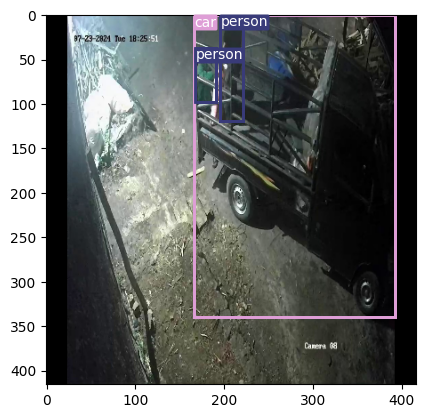

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[2.0, 1.0, 0.2350417524576187, 0.3844830095767975, 0.3595065772533417, 0.768966019153595], [2.0, 1.0, 0.2350417524576187, 0.3844830095767975, 0.3595065772533417, 0.768966019153595], [2.0, 1.0, 0.2350417524576187, 0.3844830095767975, 0.3595065772533417, 0.768966019153595]]


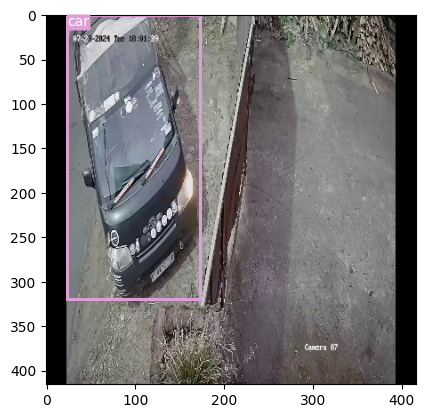

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[0.0, 1.0, 0.6012644171714783, 0.3148980140686035, 0.13100402057170868, 0.41760703921318054], [0.0, 1.0, 0.6012644171714783, 0.3148980140686035, 0.13100402057170868, 0.41760703921318054], [0.0, 1.0, 0.6012644171714783, 0.3148980140686035, 0.13100402057170868, 0.41760703921318054]]


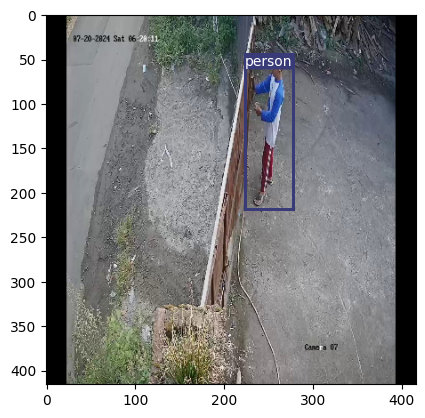

In [ ]:
def test():
    anchors = ANCHORS

    transform = test_transforms

    dataset = YOLODataset(
        "/content/dataset/test/images",
        "/content/dataset/test/labels",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    a = 0
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    for x, y in loader:
        if a >= 3:
          break
        boxes = []
        a = a + 1
        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)

if __name__ == "__main__":
    test()

# mengecek predictions data

In [ ]:
import os
import shutil

# Tentukan path folder di Google Drive dan path tujuan di Colab
gdrive_folder = '/content/drive/MyDrive/testing_for_dataloader/'
colab_folder = '/content/dataset'

# Cek apakah folder sudah ada di Colab
if not os.path.exists(colab_folder):
    # Jika folder belum ada, salin folder dari Google Drive ke Colab
    shutil.copytree(gdrive_folder, colab_folder)
    print(f"Folder {gdrive_folder} telah disalin ke {colab_folder}.")
else:
    print(f"Folder {colab_folder} sudah ada di Colab.")

Folder /content/dataset sudah ada di Colab.


In [ ]:
IMG_TEST_DIR = '/content/dataset/test/images'
LABEL_TEST_DIR = '/content/dataset/test/labels'
test_dataset = YOLODataset(
    img_dir=IMG_TEST_DIR,
    label_dir=LABEL_TEST_DIR,
    anchors=ANCHORS,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    transform=test_transforms,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
    drop_last=False,
)

In [ ]:
model = model.to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
if LOAD_MODEL:
    load_checkpoint(
      CHECKPOINT_FILE, model, optimizer, LEARNING_RATE
    )
pred_boxes, true_boxes = get_evaluation_bboxes(
    test_loader,
    model,
    iou_threshold=CONF_THRESHOLD,
    anchors=ANCHORS,
    threshold=CONF_THRESHOLD,
    device = "cuda" if torch.cuda.is_available() else "cpu"
  )

NameError: name 'optim' is not defined

In [ ]:
len(pred_boxes), pred_boxes[1:5], ('======================='), len(true_boxes), true_boxes[1:5]

In [ ]:
gambar_ke = 2
jumlah = 0
for pred_box in pred_boxes:
  if pred_box[0] == gambar_ke:
    print(pred_box)
    jumlah = jumlah + 1
print(jumlah)

In [ ]:
def test():
    anchors = torch.tensor(ANCHORS).to(DEVICE)
    transform = test_transforms

    dataset = YOLODataset(
        "/content/dataset/test/images",
        "/content/dataset/test/labels",
        S=[13, 26, 52],
        anchors=anchors.cpu().numpy(),
        transform=transform,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(DEVICE)
    a = 0
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    model.eval()  # Pastikan model dalam mode evaluasi
    a = 0
    for x, y in loader:
        if a >= 5:
            break
        x = x.to("cuda")
        with torch.no_grad():
            predictions = model(x)

        boxes = []
        for i in range(predictions[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(predictions[i].shape)
            boxes += cells_to_bboxes(
                predictions[i], is_preds=True, S=predictions[i].shape[2], anchors=anchor
            )[0]
        boxes = non_max_suppression(boxes, iou_threshold=NMS_IOU_THRESH, threshold=CONF_THRESHOLD, box_format="midpoint")
        print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
        a = a + 1

if __name__ == "__main__":
    import time

    start_time = time.time()  # Mulai menghitung waktu

    test()

    end_time = time.time()  # Selesai menghitung waktu
    print(f"Total waktu yang dibutuhkan: {end_time - start_time:.2f} detik")